In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

In [24]:
df = pd.read_csv('jacobi_acc.txt', sep=' ', header=None, names=['size', 'processes', '1000', 'comp_time', 'comm_time', 'zeros'])

# Drop the last column
df = df.drop('zeros', axis=1)
df = df.drop('1000', axis=1)
df['total_time'] = df['comp_time'] + df['comm_time']

# Sort the rows by increasing matrix size
df = df.sort_values(by=['size', 'processes'])

print(df)

     size  processes  comp_time  comm_time  total_time
0    1202          4   0.035891   0.556026    0.591917
1    1202          4   0.036444   0.514346    0.550790
2    1202          4   0.037257   0.525863    0.563120
3    1202          4   0.035357   0.516370    0.551727
4    1202          4   0.035602   0.523098    0.558700
15   1202          8   0.033450   0.673816    0.707266
16   1202          8   0.033608   0.617574    0.651182
17   1202          8   0.033419   0.580624    0.614043
18   1202          8   0.034631   0.587789    0.622420
19   1202          8   0.033310   0.580689    0.613999
30   1202         16   0.033087   0.649002    0.682089
31   1202         16   0.032559   0.597291    0.629850
32   1202         16   0.032440   0.584884    0.617324
33   1202         16   0.035731   0.588808    0.624539
34   1202         16   0.032833   0.633840    0.666673
45   1202         32   0.031488   1.234460    1.265948
46   1202         32   0.031601   1.052240    1.083841
47   1202 

In [25]:
# Group the rows by size and processes and calculate the mean of comp_time and comm_time
grouped = df.groupby(['size', 'processes']).agg({'comp_time': 'mean', 'comm_time': 'mean'}).reset_index()
grouped.insert(2, 'nodes', grouped['processes'] / grouped['processes'][0])
grouped['nodes'] = grouped['nodes'].astype(int)
grouped['total_time'] = grouped['comp_time'] + grouped['comm_time']

# Compute speedup and efficiency
grouped['speedup'] = grouped.groupby('size')['total_time'].transform(lambda x: x.iloc[0] / x)
grouped['efficiency'] = grouped['speedup'] / grouped['nodes']

grouped

,size,processes,nodes,comp_time,comm_time,total_time,speedup,efficiency
0,1202,4,1,0.036110,0.527141,0.563251,1.000000,1.000000
1,1202,8,2,0.033683,0.608098,0.641782,0.877636,0.438818
2,1202,16,4,0.033330,0.610765,0.644095,0.874484,0.218621
3,1202,32,8,0.031637,1.194722,1.226359,0.459287,0.057411
4,12002,4,1,0.847066,0.880123,1.727189,1.000000,1.000000
5,12002,8,2,0.428120,0.838341,1.266461,1.363792,0.681896
6,12002,16,4,0.227978,0.780919,1.008898,1.711957,0.427989
7,12002,32,8,0.130865,2.313982,2.444847,0.706461,0.088308
8,64002,4,1,50.185680,6.417392,56.603072,1.000000,1.000000
9,64002,8,2,23.820520,4.739060,28.559580,1.981929,0.990965


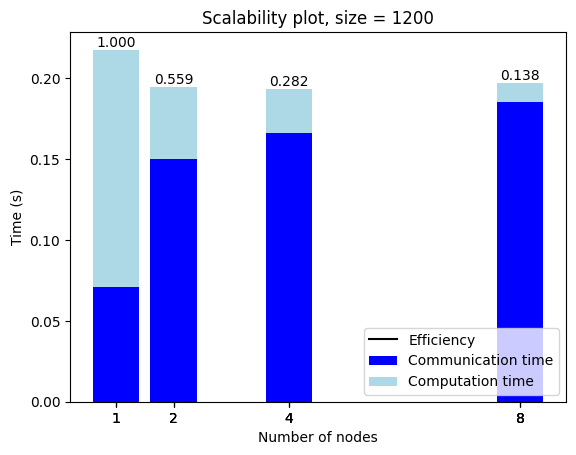

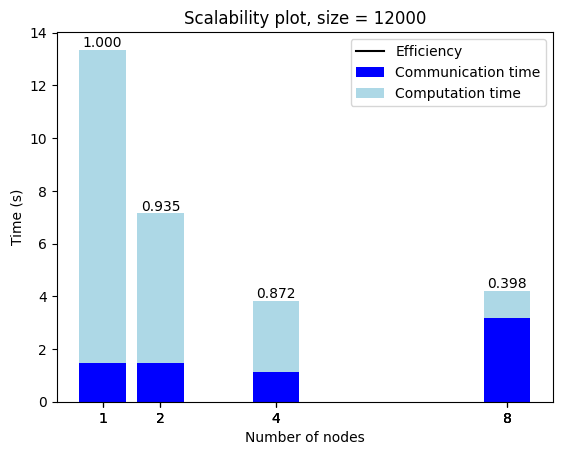

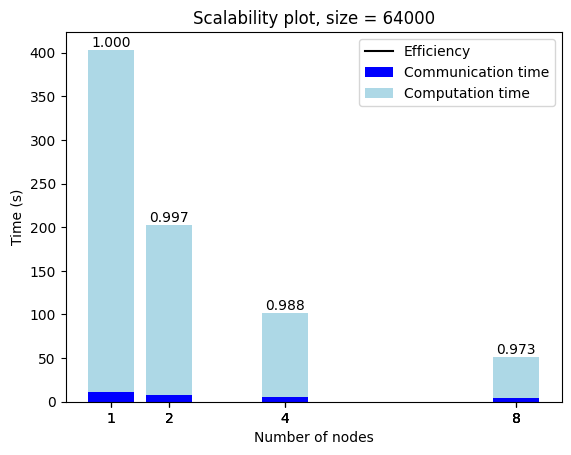

In [23]:
for size in grouped['size'].unique():
    data = grouped[grouped['size'] == size]
    plt.figure()
    bar1 = plt.bar(data['nodes'], data['comm_time'], 
            width = 0.8, label = 'Communication time',
            color = 'blue')
    bar2 = plt.bar(data['nodes'], data['comp_time'], 
            width = 0.8, bottom = data['comm_time'], 
            label = 'Computation time',
            color = 'lightblue')
    plt.xlabel('Number of nodes')
    plt.ylabel('Time (s)')
    plt.xticks(grouped['nodes'])
    plt.title(f'Scalability plot, size = {size - 2}')
    
    # Add counts above the two bar graphs
    for rect1, rect2, eff in zip(bar1, bar2, data['efficiency']):
        height = rect1.get_height() + rect2.get_height()
        plt.text(rect1.get_x() + rect1.get_width() / 2.0, height, f'{eff:.3f}', ha='center', va='bottom')
    
    # Create a dummy plot for the efficiency label
    plt.plot([], [], color='black', label='Efficiency')
    
    plt.legend()
    plt.savefig(savepath + "mpi_" + str(size-2) + ".png", dpi=200, bbox_inches="tight")
    plt.gcf().set_facecolor('white')
    plt.show()

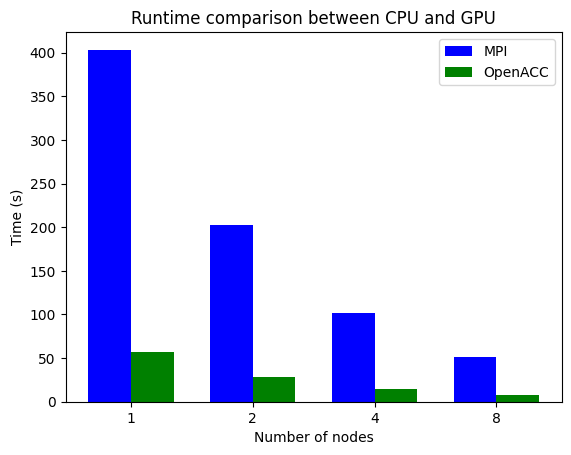

In [29]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

# Load data from gpu_scalability.txt
n_procs_gpu = np.array([1, 2, 4, 8])
tot_gpu = np.array([56.603072, 28.559580, 14.127772, 7.678766])
comp_gpu = 0

data_gpu = pd.DataFrame({'group': n_procs_gpu, 'total_time': tot_gpu, 
                     'communication_time': tot_gpu - comp_gpu})

group_stats_gpu = data_gpu.groupby('group')[['total_time', 'communication_time']].mean()

# Load data from dgemm_scalability.txt
n_procs_mpi = np.array([1, 2, 4, 8])

comp_mpi = 0

tot_mpi = np.array([403.390922, 202.337270, 102.119964, 51.821152])

data_mpi = pd.DataFrame({'group': n_procs_mpi, 'total_time': tot_mpi, 
                     'communication_time': tot_mpi - comp_mpi})

group_stats_mpi = data_mpi.groupby('group')[['total_time', 'communication_time']].mean()

# Plotting
fig, ax = plt.subplots()
index = np.arange(len(group_stats_gpu))
width = 0.35

rects1 = ax.bar(index, group_stats_mpi['total_time'], width, color='b')
rects2 = ax.bar(index + width, group_stats_gpu['total_time'], width, color='g')
xtick_labels = ['1', '2', '4', '8']

# Customizing the plot
ax.set_xlabel('Number of nodes')
ax.set_ylabel('Time (s)')
ax.set_title('Runtime comparison between CPU and GPU')
ax.set_xticks(index + width / 2)
ax.set_xticklabels(xtick_labels)
ax.legend((rects1[0], rects2[0]), ('MPI', 'OpenACC'))
fig.savefig('C:/Nicola/universita/Data_science/Parallel Programming/Comparison_64000.png', dpi=150)
plt.show()